In [19]:
import torch
import os
import cv2
import numpy as np
from ultralytics import YOLO
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models
from PIL import Image, ImageOps
from ultralytics import YOLO

In [5]:
import os
import shutil

train_dir = "./../data/VGG/train"
test_dir = "./../data/VGG/test"

# Get a list of all directories in the train directory
train_subdirs = [f for f in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, f))]

# Create corresponding directories in the test directory
for subdir in train_subdirs:
    test_subdir = os.path.join(test_dir, subdir)
    os.makedirs(test_subdir, exist_ok=True)  # Create directory if it doesn't exist


In [6]:
import random

num_files_to_move = 20

# Get a list of all directories in the train directory
train_subdirs = [f for f in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, f))]

# Iterate over each subdirectory
for subdir in train_subdirs:
    # Create corresponding directory in the test directory if it doesn't exist
    test_subdir = os.path.join(test_dir, subdir)
    os.makedirs(test_subdir, exist_ok=True)
    
    # Get list of files in the current subdirectory
    files_in_subdir = os.listdir(os.path.join(train_dir, subdir))
    
    # Randomly select 20 files
    selected_files = random.sample(files_in_subdir, min(num_files_to_move, len(files_in_subdir)))
    
    # Move selected files to the corresponding test subdirectory
    for file in selected_files:
        src_file = os.path.join(train_dir, subdir, file)
        dest_file = os.path.join(test_subdir, file)
        shutil.move(src_file, dest_file)


In [4]:
# Load the VGG model
model = models.vgg16(pretrained=False)  # Example model, replace with your loaded model
model.classifier[6] = nn.Linear(4096, 15)

# Load the state dictionary from the .pth file
checkpoint = torch.load('../weights/vgg_weights.pth')

# Load the state dictionary into the model
model.load_state_dict(checkpoint)

# Set the model to evaluation mode
model.eval()

/home/ashmitha/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ashmitha/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
test_images_path = "../data/SMALL_GTSRB/Training/images/"
test_images = os.listdir(test_images_path)

In [11]:
classes_yolo = ['20 km/h','30 km/h','50 km/h', '60 km/h', '70 km/h', '80 km/h', '100 km/h','120 km/h','Yield', 'Stop', 'Narrow Road','Men at Work', 'No Entry', '40 kmhr', 'UTurn']
classes_vgg = ['20 km/h','30 km/h', "Yield", 'stop', '50 km/h', 'narrow road', 'men at work', '60 km/h', 'no entry', '70 km/h', '40 kmhr', '80 km/h', '100 km/h','120 km/h', 'UTurn']


In [34]:
def preprocessing(img):
        img = ImageOps.equalize(img)
        return img

def vgg_recog(image):
    transform = transforms.Compose([
            transforms.ToTensor(),  # Convert the images to PyTorch tensors
            transforms.Resize((224, 224)),  # Resize the images to the desired size
            # transforms.Lambda(lambda x: preprocessing(x)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image data
        ])
    
    image = transform(image)
    image = image.unsqueeze(0)
    with torch.no_grad():
        output = model(image)

    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    probabilities_array = probabilities.numpy()
    max_index = np.argmax(probabilities_array)
    conf = np.max(probabilities_array)
    if conf > 0.5:
         return max_index
    
    else:
        return -1
    

def yolo_recog(image):
    results = yolo(image)

    for result in results:
        if len(result) !=0:
            conf = result[0].boxes.conf
            index = result[0].boxes.cls

            if conf > 0.7:
                return index
    
    return -1



         

    


    

In [35]:
total = 0
vgg_crt = 0
yolo_crt = 0

In [42]:
import time

In [43]:
for image_file in test_images:
    total += 1
    image = Image.open(test_images_path + image_file)

    label_file = "../data/SMALL_GTSRB/Training/labels/" + image_file[:-3] + "txt"
    with open(label_file, "r") as file:
        first_line = file.readline()
        elements = first_line.split()
        truth = elements[0]
        label = classes_yolo[int(truth)]
        
    # for vgg
    start_time = time.time()
    index  = vgg_recog(image)
    vgg_time = time.time() - start_time
    if index == -1:
        continue
    pred = classes_vgg[index]
    vgg_crt += (pred == label)
    print(vgg_time)
    
    # for yolo
    start_time = time.time()
    index  = yolo_recog(image)
    yolo_time = time.time() - start_time
    if index == -1:
        continue
    pred = classes_yolo[int(index.item())]
    print(yolo_time)

    yolo_crt += (pred == label)
    break
    

/home/ashmitha/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(

0: 640x640 1 Speed limit (120km/h), 85.0ms
Speed: 15.9ms preprocess, 85.0ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)


0.3826911449432373
0.12920117378234863


In [41]:
vgg_crt / total


0.5190213337311651

In [40]:
yolo_crt / total

0.7783082201999105

DETECTION MODEL ACCURACY/ PRECISION/ RECALL

In [ ]:
""" 
Detected correct, detected wrong, did not detect
"""

In [1]:
import torch
import numpy as np
import cv2
import os

In [21]:
detect_model = torch.hub.load('../yolov5/', 'custom', path='../weights/detect_weights.pt', force_reload=True, source='local')

YOLOv5 🚀 v7.0-212-g9974d51 Python-3.8.10 torch-2.0.1+cu117 CPU

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [3]:
test_images_path = "/home/ashmitha/traffic_sign_detection/data/GTSDB/train_detection/images"
test_images = os.listdir(test_images_path)



In [8]:
len(test_images)

592

In [4]:
for image_file in test_images:
    frame = cv2.imread(test_images_path + "/" + image_file)
    results = detect_model(frame)

    bounding_boxes = results.xyxy[0].cpu().numpy()
    
    for box in bounding_boxes:
        x_min, y_min, x_max, y_max, confidence, class_id = box

        cv2.rectangle(frame, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

    cv2.imshow("frame", frame)



    if cv2.waitKey(0) & 0xFF == ord('n'):
        continue


In [ ]:
cv2.destroyAllWindows()

In [ ]:
# correct = 229 true positive
# not detected = 37 false negative
# wrong detect = 24 false positive

RECOGNITION MODEL ACCURACY/ PRECISION/ RECALL

In [11]:
from ultralytics import YOLO

In [9]:
recog_model_5 = torch.hub.load('../yolov5/', 'custom', path='../weights/best (2).pt', force_reload=True, source='local')

YOLOv5 🚀 v7.0-212-g9974d51 Python-3.8.10 torch-2.0.1+cu117 CPU

Fusing layers... 
Model summary: 157 layers, 7126096 parameters, 0 gradients, 16.1 GFLOPs
Adding AutoShape... 


In [12]:
recog_model_8 = YOLO('../weights/recog_weights.pt')  


In [5]:
test_images_path = "/home/ashmitha/traffic_sign_detection/test_images/Test"
test_images = os.listdir(test_images_path)



In [6]:
total = 0

In [ ]:
for image_file in test_images:
    if total == 500:
        break
    total += 1

    frame = cv2.imread(test_images_path + "/" + image_file)

    predict = recog_model_8(frame)
    
    cv2.imshow("frame", frame)

    if cv2.waitKey(0) & 0xFF == ord('n'):
        continue

In [20]:
def red_color_seg(image):

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # lower boundary RED color range values; Hue (0 - 10)
    lower1 = np.array([0, 120, 0])
    upper1 = np.array([10, 255, 255])

    # upper boundary RED color range values; Hue (160 - 180)
    lower2 = np.array([160,120,0])
    upper2 = np.array([185,255,255])

    lower_mask = cv2.inRange(hsv_image, lower1, upper1)
    upper_mask = cv2.inRange(hsv_image, lower2, upper2)
    red_mask = lower_mask | upper_mask

    red_seg = cv2.bitwise_and(image, image, mask=red_mask)
    cv2.imwrite("stage1.jpg", red_seg)


    # dont change 5
    kernel = np.ones((5, 5), np.uint8)
    red_mask = cv2.dilate(red_mask, kernel, iterations=1)
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel)
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, kernel)

    # kernel = np.ones((7, 7), np.uint8)

    red_segmented_image = cv2.bitwise_and(image, image, mask=red_mask)
    # cv2.imwrite("stage2.jpg", red_segmented_image)
    # red_segmented_image = cv2.fastNlMeansDenoisingColored(red_segmented_image, None,30,30,15,30) 

    gray = cv2.cvtColor(red_segmented_image, cv2.COLOR_BGR2GRAY)

    # Find contours in the opened maskqqqqqqqqq
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_area_threshold = 100
    max_area_threshold = 8000
    # Filter out contours with area less than the threshold and fill them with black color
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < min_area_threshold or area > max_area_threshold:
            cv2.drawContours(gray, [contour], 0, (0, 255, 0), -1)



    # kernel = np.ones((3, 3), np.uint8)
    # red_mask = cv2.erode(red_mask, kernel, iterations=1)
    red_segmented_image = cv2.bitwise_and(image, image, mask=gray)
    # cv2.imwrite("stage3.jpg", red_segmented_image)
    # print(red_segmented_image.shape)

    

    # red_segmented_image = cv2.GaussianBlur(red_segmented_image, (7, 7), 0)
    # red_segmented_image = cv2.fastNlMeansDenoisingColored(red_segmented_image, None,30,30,10,30) 
    # red_segmented_image = cv2.GaussianBlur(red_segmented_image, (5, 5), 0)
    # image = cv2.addWeighted(image, 1, red_segmented_image, 0.5, 0)

    return red_segmented_image, gray
    # cv2.imshow("out", red_segmented_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

VIDEO

In [ ]:
detection_data = []
recog_data = []

In [24]:

video_capture = cv2.VideoCapture('/home/ashmitha/traffic_sign_detection/test_images/night_dtraight.mkv')

start_time_seconds = 1

# Calculate the starting frame number
fps = video_capture.get(cv2.CAP_PROP_FPS)
start_frame = int(start_time_seconds * fps)

# Set the starting frame position
video_capture.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# frame_rate = video_capture.get(cv2.CAP_PROP_FPS)
# print(frame_rate)

# # Calculate the new frame rate (double the original frame rate)
# new_frame_rate = frame_rate * 10

# # Set the new frame rate for the video capture
# video_capture.set(cv2.CAP_PROP_FPS, new_frame_rate)
# frame_rate = video_capture.get(cv2.CAP_PROP_FPS)
# print(frame_rate)

predictions = []


[ERROR:0@3430.566] global cap.cpp:164 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.8.0) /io/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): /home/ashmitha/traffic_sign_detection/test_images/night_dtraight.mkv in function 'icvExtractPattern'




In [28]:
def decision_criteria(predicted):
    predicted =  np.array(predicted)
    predicted_classes = predicted[:, 0]
    confidences = predicted[:,1]
    
    unique_classes, class_counts = np.unique(predicted_classes, return_counts=True)
    
    for class_, count in zip(unique_classes, class_counts):
        if count >= 8:
            class_indices = np.where(predicted_classes == class_)[0]
            class_confidences = confidences[class_indices]
            median_confidence = np.median(class_confidences)
            
            if median_confidence > 0.85:
                return True
    
    return False

In [26]:
test_vdos_dir = os.listdir("../test_images/Day/")

In [32]:
for path in test_vdos_dir:
    video_capture = cv2.VideoCapture('../test_images/Day/' + path)
    

    while True:
        # Read the next frame
        ret, frame = video_capture.read()
        try:
            frame_copy = frame.copy()
        except AttributeError:
            # Handle the case where frame is None
            print("No more frames to read. Exiting loop.")
            break
        
        # MAsk    # Read the next frame
        ret, frame = video_capture.read()
        frame_copy = frame.copy()
        
        # MAsk
        seg_frame, mask = red_color_seg(frame)

        # Detection
        results = detect_model(frame)
        bounding_boxes = results.xyxy[0].cpu().numpy()
        
        for box in bounding_boxes:
            x_min, y_min, x_max, y_max, confidence, class_id = box

            # intersection and alter the confidence
            if not mask[int(y_min):int(y_max), int(x_min):int(x_max)].any():
                confidence = confidence * 0.5

            # Threshold for detection
            if  confidence > 0.4:
                cropped_img = frame_copy[int(y_min):int(y_max), int(x_min):int(x_max)]

                # Recognition Model
                predict = model(cropped_img, verbose = False)

                for result in predict:
                    class_probs = result.probs
                    class_names = model.names

                    max_prob_index = class_probs.top1
                    confidence_r = class_probs.top1conf.item()  

                    if confidence_r > 0.65:

                        predicted_class = class_names[max_prob_index]

                        predictions.append([max_prob_index, confidence_r])
                        if len(predictions) > 15:
                            predictions = predictions[1:]

                        if decision_criteria(predictions):
                            class_recog = predicted_class
                            cv2.putText(frame_copy, predicted_class + "sign DETECTED", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
                            cv2.rectangle(frame_copy, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
                            start = video_capture.get(cv2.CAP_PROP_POS_MSEC)
                            predictions = []


                            while True:
                            
                                ret, frame = video_capture.read()
                                cv2.imshow("Original vs Processed", frame)
                                if cv2.waitKey(0) & 0xFF == ord('e'):
                                    predictions = []
                                    gap = video_capture.get(cv2.CAP_PROP_POS_MSEC) - start
                                    print(f"Gap: {gap} | Predicted Class: {class_recog}")
                                    break

                                if cv2.waitKey(0) & 0xFF == ord('n'):
                                    continue
                            
                            
                        

        # Display the concatenated frame
        cv2.imshow("Original vs Processed", frame_copy)
        

        # # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):

            break

        if cv2.waitKey(0) & 0xFF == ord('e'):
            predictions = []


        if cv2.waitKey(0) & 0xFF == ord('n'):
            continue

            


    # Release the video capture object and close the display window
    video_capture.release()
    cv2.destroyAllWindows()
        

Gap: 30100.0 | Predicted Class: 25
Gap: 2366.0 | Predicted Class: 3
Gap: 1633.0 | Predicted Class: 32
Gap: 1767.0 | Predicted Class: 37
Gap: 1533.0 | Predicted Class: 1
Gap: 11233.0 | Predicted Class: 24
Gap: 1434.0 | Predicted Class: 1


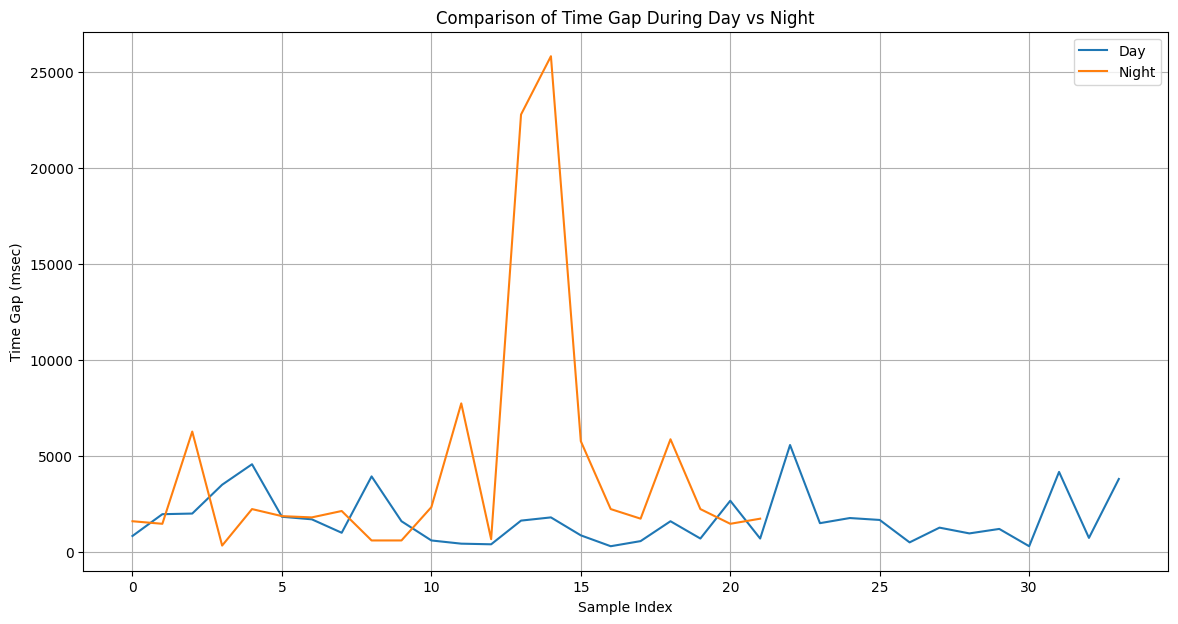

In [4]:
import matplotlib.pyplot as plt

# List of gap values
gaps_day = [
    833.0, 1967.0, 2000.0, 3500.0, 4566.0, 1833.0000000000073, 1700.0000000000146,
    1000.0, 3933.0, 1600.0, 599.9999999999854, 433.0, 399.99999999998545, 1633.0,
    1800.0, 866.0, 300.0, 566.0, 1600.0, 699.9999999999982, 2667.000000000002, 700.0,
    5567.0, 1500.0, 1767.0, 1667.0, 500.0, 1267.0, 967.0, 1200.0000000000018,
    300.0000000000018, 4167.0, 733.0, 3800.0]

gaps_night= [  
    1600.0000000000018, 1466.9999999999982,
    6267.0, 334.00000000000045, 2232.999999999999, 1866.0000000000018, 1800.0,
    2133.0, 600.0, 600.0, 2334.000000000001, 7733.000000000002, 667.0, 22767.0,
    25800.0, 5766.0, 2233.0, 1734.0, 5865.999999999998, 2232.9999999999964, 1467.0, 1733.0
]
 
# Creating the plot
plt.figure(figsize=(14, 7))
plt.plot(gaps_day, label='Day', )
plt.plot(gaps_night, label='Night', )

# plt.plot(gaps_day, label='Day', marker='o')
# plt.plot(gaps_night, label='Night', marker='o')

plt.title('Comparison of Time Gap During Day vs Night')
plt.xlabel('Sample Index')
plt.ylabel('Time Gap (msec)')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


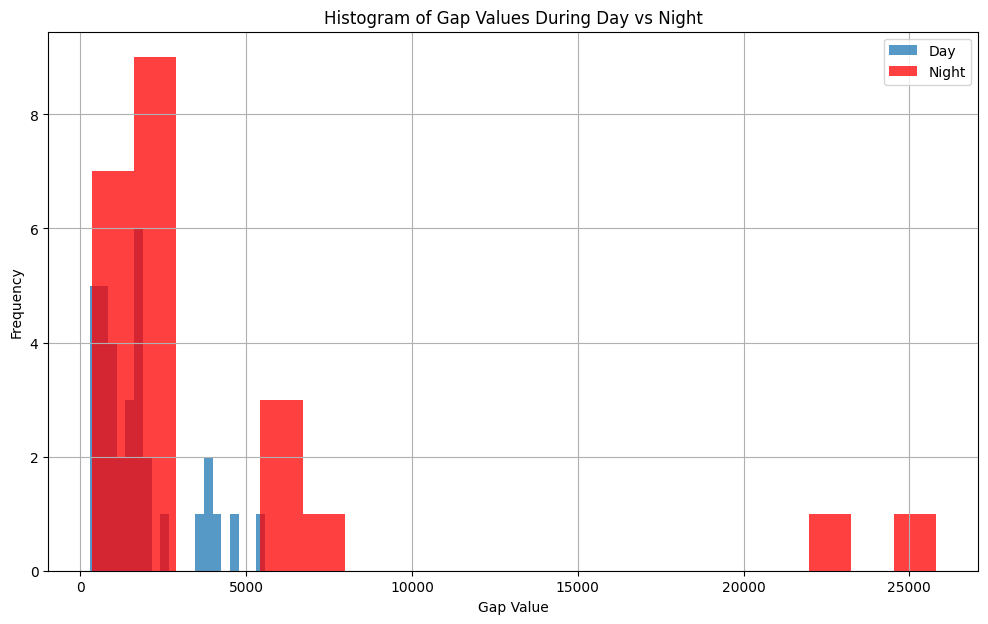

In [5]:
plt.figure(figsize=(12, 7))
plt.hist(gaps_day, bins=20, alpha=0.75, label='Day')
plt.hist(gaps_night, bins=20, alpha=0.75, label='Night', color='red')
plt.title('Histogram of Gap Values During Day vs Night')
plt.xlabel('Gap Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

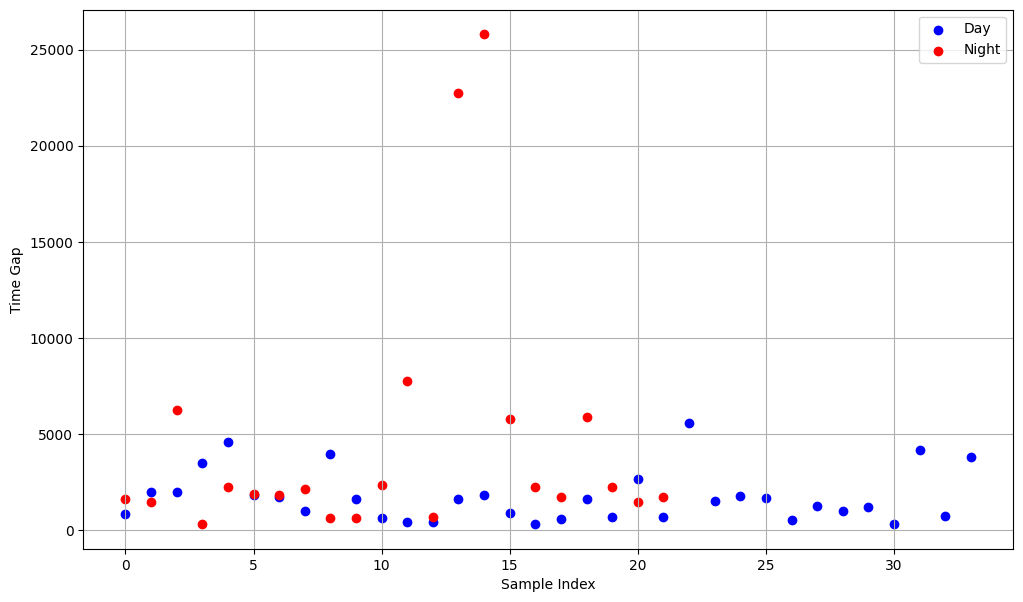

In [7]:
# Plot indices for day and night
indices_day = list(range(len(gaps_day)))
indices_night = list(range(len(gaps_night)))

# Creating the scatter plot
plt.figure(figsize=(12, 7))
plt.scatter(indices_day, gaps_day, color='blue', label='Day')
plt.scatter(indices_night, gaps_night, color='red', label='Night')
plt.xlabel('Sample Index')
plt.ylabel('Time Gap')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

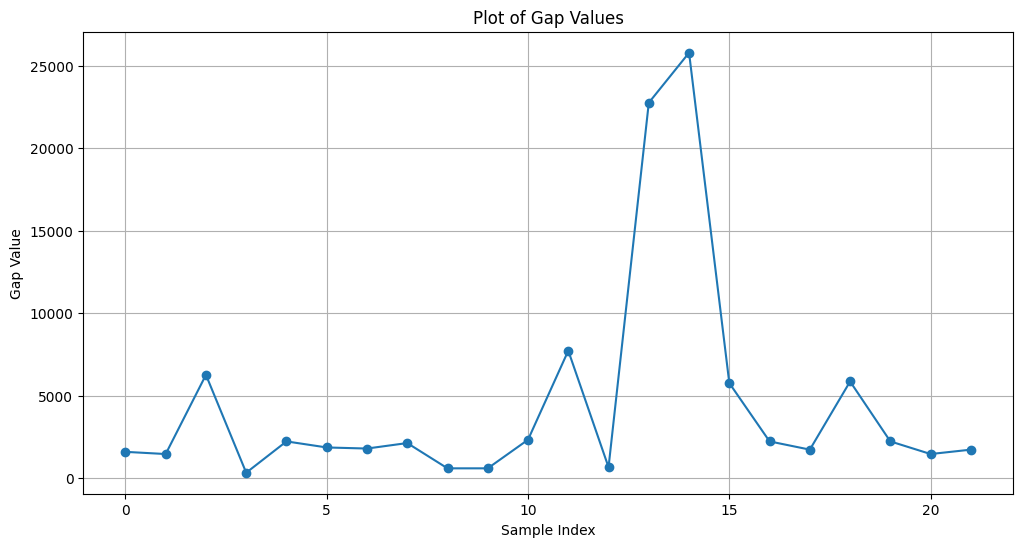

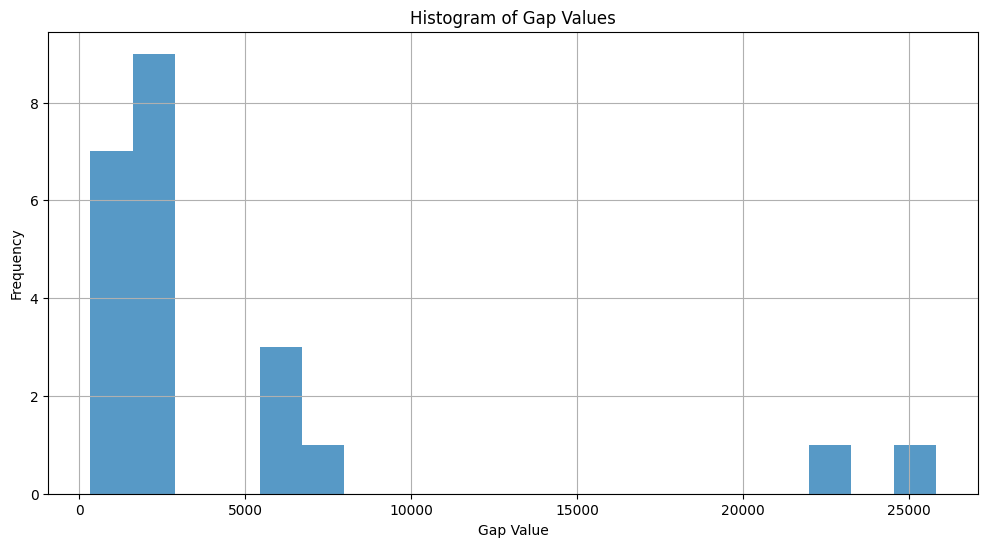

In [2]:
gaps_day = [  
    1600.0000000000018, 1466.9999999999982,
    6267.0, 334.00000000000045, 2232.999999999999, 1866.0000000000018, 1800.0,
    2133.0, 600.0, 600.0, 2334.000000000001, 7733.000000000002, 667.0, 22767.0,
    25800.0, 5766.0, 2233.0, 1734.0, 5865.999999999998, 2232.9999999999964, 1467.0, 1733.0
]

# Plotting the raw gap values
plt.figure(figsize=(12, 6))
plt.plot(gaps_day, marker='o', linestyle='-')
plt.title('Plot of Gap Values')
plt.xlabel('Sample Index')
plt.ylabel('Gap Value')
plt.grid(True)

# Showing the first plot
plt.show()

# Plotting a histogram of the gap values
plt.figure(figsize=(12, 6))
plt.hist(gaps_day, bins=20, alpha=0.75)
plt.title('Histogram of Gap Values')
plt.xlabel('Gap Value')
plt.ylabel('Frequency')
plt.grid(True)

# Showing the histogram
plt.show()

In [8]:
import numpy as np

# Gap values for day and night
gaps_day = [
    833.0, 1967.0, 2000.0, 3500.0, 4566.0, 1833.0000000000073, 1700.0000000000146,
    1000.0, 3933.0, 1600.0, 599.9999999999854, 433.0, 399.99999999998545, 1633.0,
    1800.0, 866.0, 300.0, 566.0, 1600.0, 699.9999999999982, 2667.000000000002, 700.0,
    5567.0, 1500.0, 1767.0, 1667.0, 500.0, 1267.0, 967.0, 1200.0000000000018,
    300.0000000000018, 4167.0, 733.0, 3800.0
]

gaps_night = [
    1600.0000000000018, 1466.9999999999982,
    6267.0, 334.00000000000045, 2232.999999999999, 1866.0000000000018, 1800.0,
    2133.0, 600.0, 600.0, 2334.000000000001, 7733.000000000002, 667.0, 22767.0,
    25800.0, 5766.0, 2233.0, 1734.0, 5865.999999999998, 2232.9999999999964, 1467.0, 1733.0
]

# Define the ranges
ranges = [(0, 1000), (1001, 2000), (2001, 3000), (3001, 4000), (4001, float('inf'))]

# Function to categorize gaps
def categorize_gaps(gaps):
    counts = np.zeros(len(ranges))
    for gap in gaps:
        for i, (low, high) in enumerate(ranges):
            if low <= gap <= high:
                counts[i] += 1
                break
    return counts

# Categorize the day and night gaps
day_counts = categorize_gaps(gaps_day)
night_counts = categorize_gaps(gaps_night)

# Calculate percentages
day_percentages = (day_counts / len(gaps_day)) * 100
night_percentages = (night_counts / len(gaps_night)) * 100

# Printing the table
print("Range (ms)\tDay (%)\tNight (%)")
for i, (low, high) in enumerate(ranges):
    print(f"{low} to {high}\t{day_percentages[i]:.2f}%\t{night_percentages[i]:.2f}%")


Range (ms)	Day (%)	Night (%)
0 to 1000	41.18%	18.18%
1001 to 2000	38.24%	31.82%
2001 to 3000	2.94%	22.73%
3001 to 4000	8.82%	0.00%
4001 to inf	8.82%	27.27%


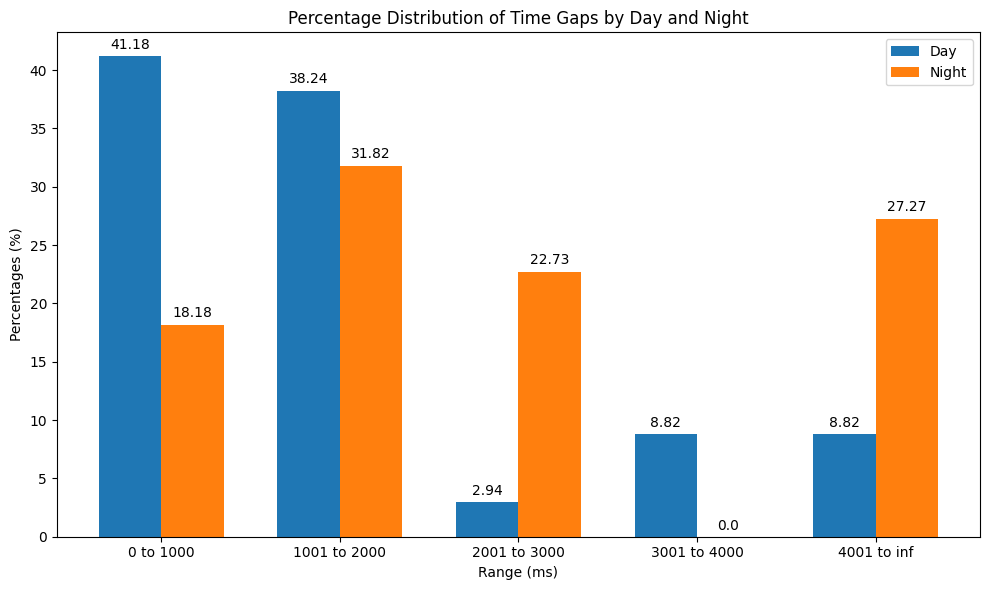

In [9]:
import matplotlib.pyplot as plt

# Data from the table
ranges = ["0 to 1000", "1001 to 2000", "2001 to 3000", "3001 to 4000", "4001 to inf"]
day_percentages = [41.18, 38.24, 2.94, 8.82, 8.82]
night_percentages = [18.18, 31.82, 22.73, 0.00, 27.27]

x = range(len(ranges))  # the label locations

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35  # the width of the bars

rects1 = ax.bar(x, day_percentages, bar_width, label='Day')
rects2 = ax.bar([p + bar_width for p in x], night_percentages, bar_width, label='Night')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Range (ms)')
ax.set_ylabel('Percentages (%)')
ax.set_title('Percentage Distribution of Time Gaps by Day and Night')
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(ranges)
ax.legend()

# Function to add a label above each bar
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call the function to attach the labels on the bars
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


In [6]:
classes = ['20 km/h','30 km/h','50 km/h', '60 km/h', '70 km/h', '80 km/h', '100 km/h','120 km/h','Yield', 'Stop', 'Narrow Road','Men at Work', 'No Entry']

In [146]:
import matplotlib.pyplot as plt

In [236]:
start_time = 0


In [237]:
file = 0

In [175]:
import csv

In [257]:
first_det = True

In [268]:
while True:
    # Read the next frame
    ret, frame = video_capture.read()
    # cv2.imshow("out", frame)

    frame_copy = frame.copy()
    
    seg_frame, mask = red_color_seg(frame)

    results = detect_model(frame)

    bounding_boxes = results.xyxy[0].cpu().numpy()
    
    for box in bounding_boxes:
        x_min, y_min, x_max, y_max, confidence, class_id = box

        if not mask[int(y_min):int(y_max), int(x_min):int(x_max)].any():
            confidence = confidence * 0.5

        if  confidence > 0.4:
            cropped_img = frame_copy[int(y_min):int(y_max), int(x_min):int(x_max)]
            predict = model(cropped_img, verbose = False)

            for result in predict:
                # Get the predicted class labels and probabilities
                class_probs = result.probs
                class_names = model.names

                # Find the index of the class with the highest probability
                max_prob_index = class_probs.top1
                confidence_r = class_probs.top1conf.item()  # Maximum probability value

                # Get the predicted class label using the index
                predicted_class = class_names[max_prob_index]


        
                cv2.putText(frame_copy, predicted_class, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
                cv2.rectangle(frame_copy, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
                detection_data.append([video_capture.get(cv2.CAP_PROP_POS_MSEC) - start_time, confidence])
                recog_data.append([video_capture.get(cv2.CAP_PROP_POS_MSEC) - start_time, confidence_r, predicted_class])

                if first_det:
                    time_gap = video_capture.get(cv2.CAP_PROP_POS_MSEC)-start_time
                    first_det = False

    # for box in bounding_boxes:
    #     x_min, y_min, x_max, y_max, confidence, class_id = box
    #     if confidence > 0.4:
    #         cv2.rectangle(frame_copy, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)



    concatenated_frame = cv2.hconcat([frame, seg_frame])


    # Display the concatenated frame
    cv2.imshow("Original vs Processed", frame_copy)
    

    # # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    if cv2.waitKey(0) & 0xFF == ord('n'):
        continue

    if cv2.waitKey(0) & 0xFF == ord('s'):
        detection_data = []
        recog_data = []
        first_det = True

        start_time = cv2.CAP_PROP_POS_MSEC



    if cv2.waitKey(0) & 0xFF == ord('e'):
        if len(detection_data) == 0:
            continue
        detection_data = np.array(detection_data)
        recog_data = np.array(recog_data)

        fig, (ax1, ax2) = plt.subplots(1, 2)

        # Plot data on the first subplot
        ax1.plot(detection_data[:, 0], detection_data[:, 1], 'r-')
        ax1.set_title(f'Detection plot | time gap = {time_gap}')

        # Plot data on the second subplot
        ax2.plot(recog_data[:, 0].astype(np.float32), recog_data[:, 1].astype(np.float32), 'b-')
        ax2.set_title('Recognition Plot')

        # Adjust layout to prevent overlapping
        plt.tight_layout()

# Save the plot as an image (e.g., PNG format)
        plt.savefig(f'plot_image_{file}.png')


        with open("pred_class.csv", 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)

            writer.writerow(recog_data)
        detection_data = []
        recog_data = []

     
        file += 1



# Release the video capture object and close the display window
video_capture.release()
cv2.destroyAllWindows()

In [215]:
        recog_data = []


In [208]:
import matplotlib.pyplot as plt

# Assuming recog_data is a NumPy array
# recog_data[:, 0] represents the x-values, and recog_data[:, 1] represents the y-values
# recog_data = recog_data[:,0].astype(np.float32)
recog_data = recog_data[:,1].astype(np.float32)


# Plot the data
plt.plot(recog_data[:, 0], recog_data[:, 1], 'b-')

# Set the title of the plot
plt.title('Recognition Plot')

# Show the plot
plt.show()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [204]:
recog_data[:, 0]

array(['13634.0', '13668.000000000002', '13701.0', '13834.0', '13868.0', '13901.0', '13901.0', '13934.000000000002', '13934.000000000002', '13968.0', '13968.0', '14001.0', '14034.0', '14068.0', '14134.0', '14168.000000000002', '14201.0', '14234.0', '14301.0', '14334.0', '14368.0', '14401.0', '14434.000000000002',
       '14468.0', '14468.0', '14501.0', '14568.0', '14601.0', '14634.0', '14668.000000000002', '14701.0', '14734.0', '14768.0', '14768.0', '14801.0', '14868.0', '14868.0', '14934.000000000002', '14968.0', '15001.0', '15034.0', '15134.0', '15168.000000000002'], dtype='<U32')

YOLO with new classes

In [30]:
from ultralytics import YOLO

# Load a model
model = YOLO('./yolov8n-cls.yaml').load('yolov8n-cls.pt')  # build from YAML and transfer weights

# Train the model
results = model.train(data='../data/VGG/', epochs=5, imgsz=64)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

YOLOv8n-cls summary: 99 layers, 2719288 parameters, 2719288 gradients, 4.4 GFLOPs
Transferred 158/158 items from pretrained weights
New https://pypi.org/project/ultralytics/8.2.6 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.164 🚀 Python-3.8.10 torch-2.0.1+cu117 CPU (11th Gen Intel Core(TM) i7-1195G7 2.90GHz)
engine/trainer: task=classify, mode=train, model=./yolov8n-cls.yaml, data=../data/VGG/, epochs=5, patience=50, batch=16, imgsz=64, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=F

In [6]:
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

# Assuming model expects 640x640 images
transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
])

# Load test dataset
test_dataset = ImageFolder(root=test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Function to get predictions
def get_predictions(model, loader):
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to track gradients
        for images, labels in loader:
            predictions = model(images)  # Get model predictions
            _, predicted_classes = torch.max(predictions, 1)
            all_preds.extend(predicted_classes.numpy())
            all_labels.extend(labels.numpy())

    return all_labels, all_preds

# Collect all predictions and true labels
true_labels, predictions = get_predictions(model, test_loader)



0: 640x640 37 0.14, 13 0.10, 40kmhr 0.08, 4 0.07, 8 0.06, 1: 640x640 37 0.16, 13 0.09, 40kmhr 0.08, 2 0.07, 4 0.06, 2: 640x640 37 0.13, 40kmhr 0.12, 13 0.10, 4 0.08, 8 0.08, 3: 640x640 40kmhr 0.14, 37 0.10, 13 0.10, 25 0.08, 32 0.06, 4: 640x640 40kmhr 0.13, 37 0.13, 13 0.10, 32 0.07, 25 0.07, 5: 640x640 40kmhr 0.12, 37 0.10, 13 0.08, 25 0.08, 2 0.07, 6: 640x640 40kmhr 0.13, 37 0.12, 13 0.11, 25 0.07, 2 0.06, 7: 640x640 13 0.11, 37 0.09, 40kmhr 0.08, 32 0.07, 1 0.07, 8: 640x640 37 0.16, 13 0.12, 40kmhr 0.09, 4 0.08, 8 0.08, 9: 640x640 37 0.12, 13 0.11, 40kmhr 0.08, 4 0.07, 8 0.07, 10: 640x640 37 0.20, 13 0.10, 40kmhr 0.08, 2 0.07, 7 0.06, 11: 640x640 37 0.19, 40kmhr 0.12, 13 0.11, 8 0.08, 4 0.08, 12: 640x640 37 0.14, 40kmhr 0.10, 13 0.10, 4 0.08, 8 0.07, 13: 640x640 37 0.16, 13 0.09, 40kmhr 0.08, 4 0.07, 2 0.06, 14: 640x640 37 0.12, 13 0.11, 40kmhr 0.10, 4 0.06, 32 0.06, 15: 640x640 37 0.15, 13 0.13, 40kmhr 0.09, 8 0.08, 4 0.07, 16: 640x640 40kmhr 0.14, 13 0.13, 37 0.12, 4 0.10, 8 0.09

TypeError: max() received an invalid combination of arguments - got (list, int), but expected one of:
 * (Tensor input, *, Tensor out)
 * (Tensor input, Tensor other, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, tuple of Tensors out)
 * (Tensor input, name dim, bool keepdim, *, tuple of Tensors out)


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plotting
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.show()


In [108]:
image_path = '../data/VGG/test/40kmhr/1.jpg'
image = cv2.imread(image_path)

# Perform inference on the image
predictions = model(image, verbose = True)

# Display the inference results


0: 64x64 40kmhr 1.00, UTurn 0.00, 0 0.00, 8 0.00, 1 0.00, 2.5ms
Speed: 0.7ms preprocess, 2.5ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)


In [8]:
true_labels = []
predicted_labels = []

In [9]:
# Initialize variables to store prediction results
total_images = 0
correct_predictions = 0

test_dir = "/home/ashmitha/traffic_sign_detection/data/VGG/test/"

# Iterate through each class folder in the test dataset
for class_name in os.listdir(test_dir):
    class_dir = os.path.join(test_dir, class_name)
    
    # Iterate through each image in the class folder
    for image_file in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_file)
        
        # Perform prediction on the image
        results = model(image_path, verbose = False)

        for result in results:
            # Get the predicted class labels and probabilities
            class_probs = result.probs
            class_names = model.names

            # Find the index of the class with the highest probability
            max_prob_index = class_probs.top1

            # Get the predicted class label using the index
            predicted_class = class_names[max_prob_index]

            true_labels.append(class_name)
            predicted_labels.append(predicted_class)



        # Update counts
        total_images += 1
        if predicted_class == class_name:
            correct_predictions += 1

# Calculate overall accuracy

In [15]:
true_labels

['25',
 '25',
 '25',
 '25',
 '25',
 '25',
 '25',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '37',
 '32',
 '32',
 '32',
 '32',
 '32',
 '32',
 '32',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '40kmhr',
 '40kmhr',
 '40kmhr',
 '40kmhr',
 '40kmhr',
 '40kmhr',
 '40kmhr',
 '40kmhr',
 '7',
 '7',
 '7',
 '7',
 '7',
 '7',
 '7',
 'UTurn',
 'UTurn',
 'UTurn',
 'UTurn',
 'UTurn',
 'UTurn',
 'UTurn',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '24',
 '24',
 '24',
 '24',
 '24',
 '24',
 '24',
 '13',
 '13',
 '13',
 '13',
 '13',
 '13',
 '13',
 '14',
 '14',
 '14',
 '14',
 '14',
 '14',
 '14']

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=list(set(true_labels)))

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(true_labels), yticklabels=set(true_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


<Figure size 1000x800 with 2 Axes>

In [123]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

In [126]:
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

In [129]:
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.9901201493687107
Recall: 0.99
F1-score: 0.990017630134565


In [120]:
accuracy = correct_predictions / total_images


In [121]:
total_images

1800

In [122]:
accuracy

0.99

In [96]:
preds

[['25', '2'],
 ['8', '2'],
 ['3', '7'],
 ['5', '1'],
 ['32', '7'],
 ['2', '2'],
 ['1', '1'],
 ['40kmhr', '12'],
 ['7', '1'],
 ['UTurn', '14'],
 ['0', '8'],
 ['4', '2'],
 ['24', '3'],
 ['13', '2'],
 ['14', '1']]